<a href="https://www.kaggle.com/code/erkanhatipoglu/introduction-to-sklearn-pipelines-with-titanic?scriptVersionId=106637000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction   <a id='introduction'></a>

This notebook is designed to be an introductory level tutorial for using pipelines from the Scikit-learn library. We will be using the well-known Titanic dataset for this purpose. Although we will submit a solution, in the end, I have no intention of getting a good accuracy score from our model. The model will be used for learning purposes only and will probably overfit the data.

By the end of this notebook, we will understand how to make pipelines by chaining multiple estimators, how to use column transformers and feature unions for parallel processing within pipelines, and how to implement derived custom transformer classes for series processing within pipelines.

We will also use encoders and imputers within our pipelines and understand the fit-transform mechanism. We will use a very complex model to do all these jobs, which will definitely overfit the data. We will see this by comparing our cross-validation results and the test score.

Please feel free to correct me if I've made mistakes, and also, if you face any problems or cannot implement the code, just let me know via the comments. I will try to answer as soon as possible. Thank you for reading.


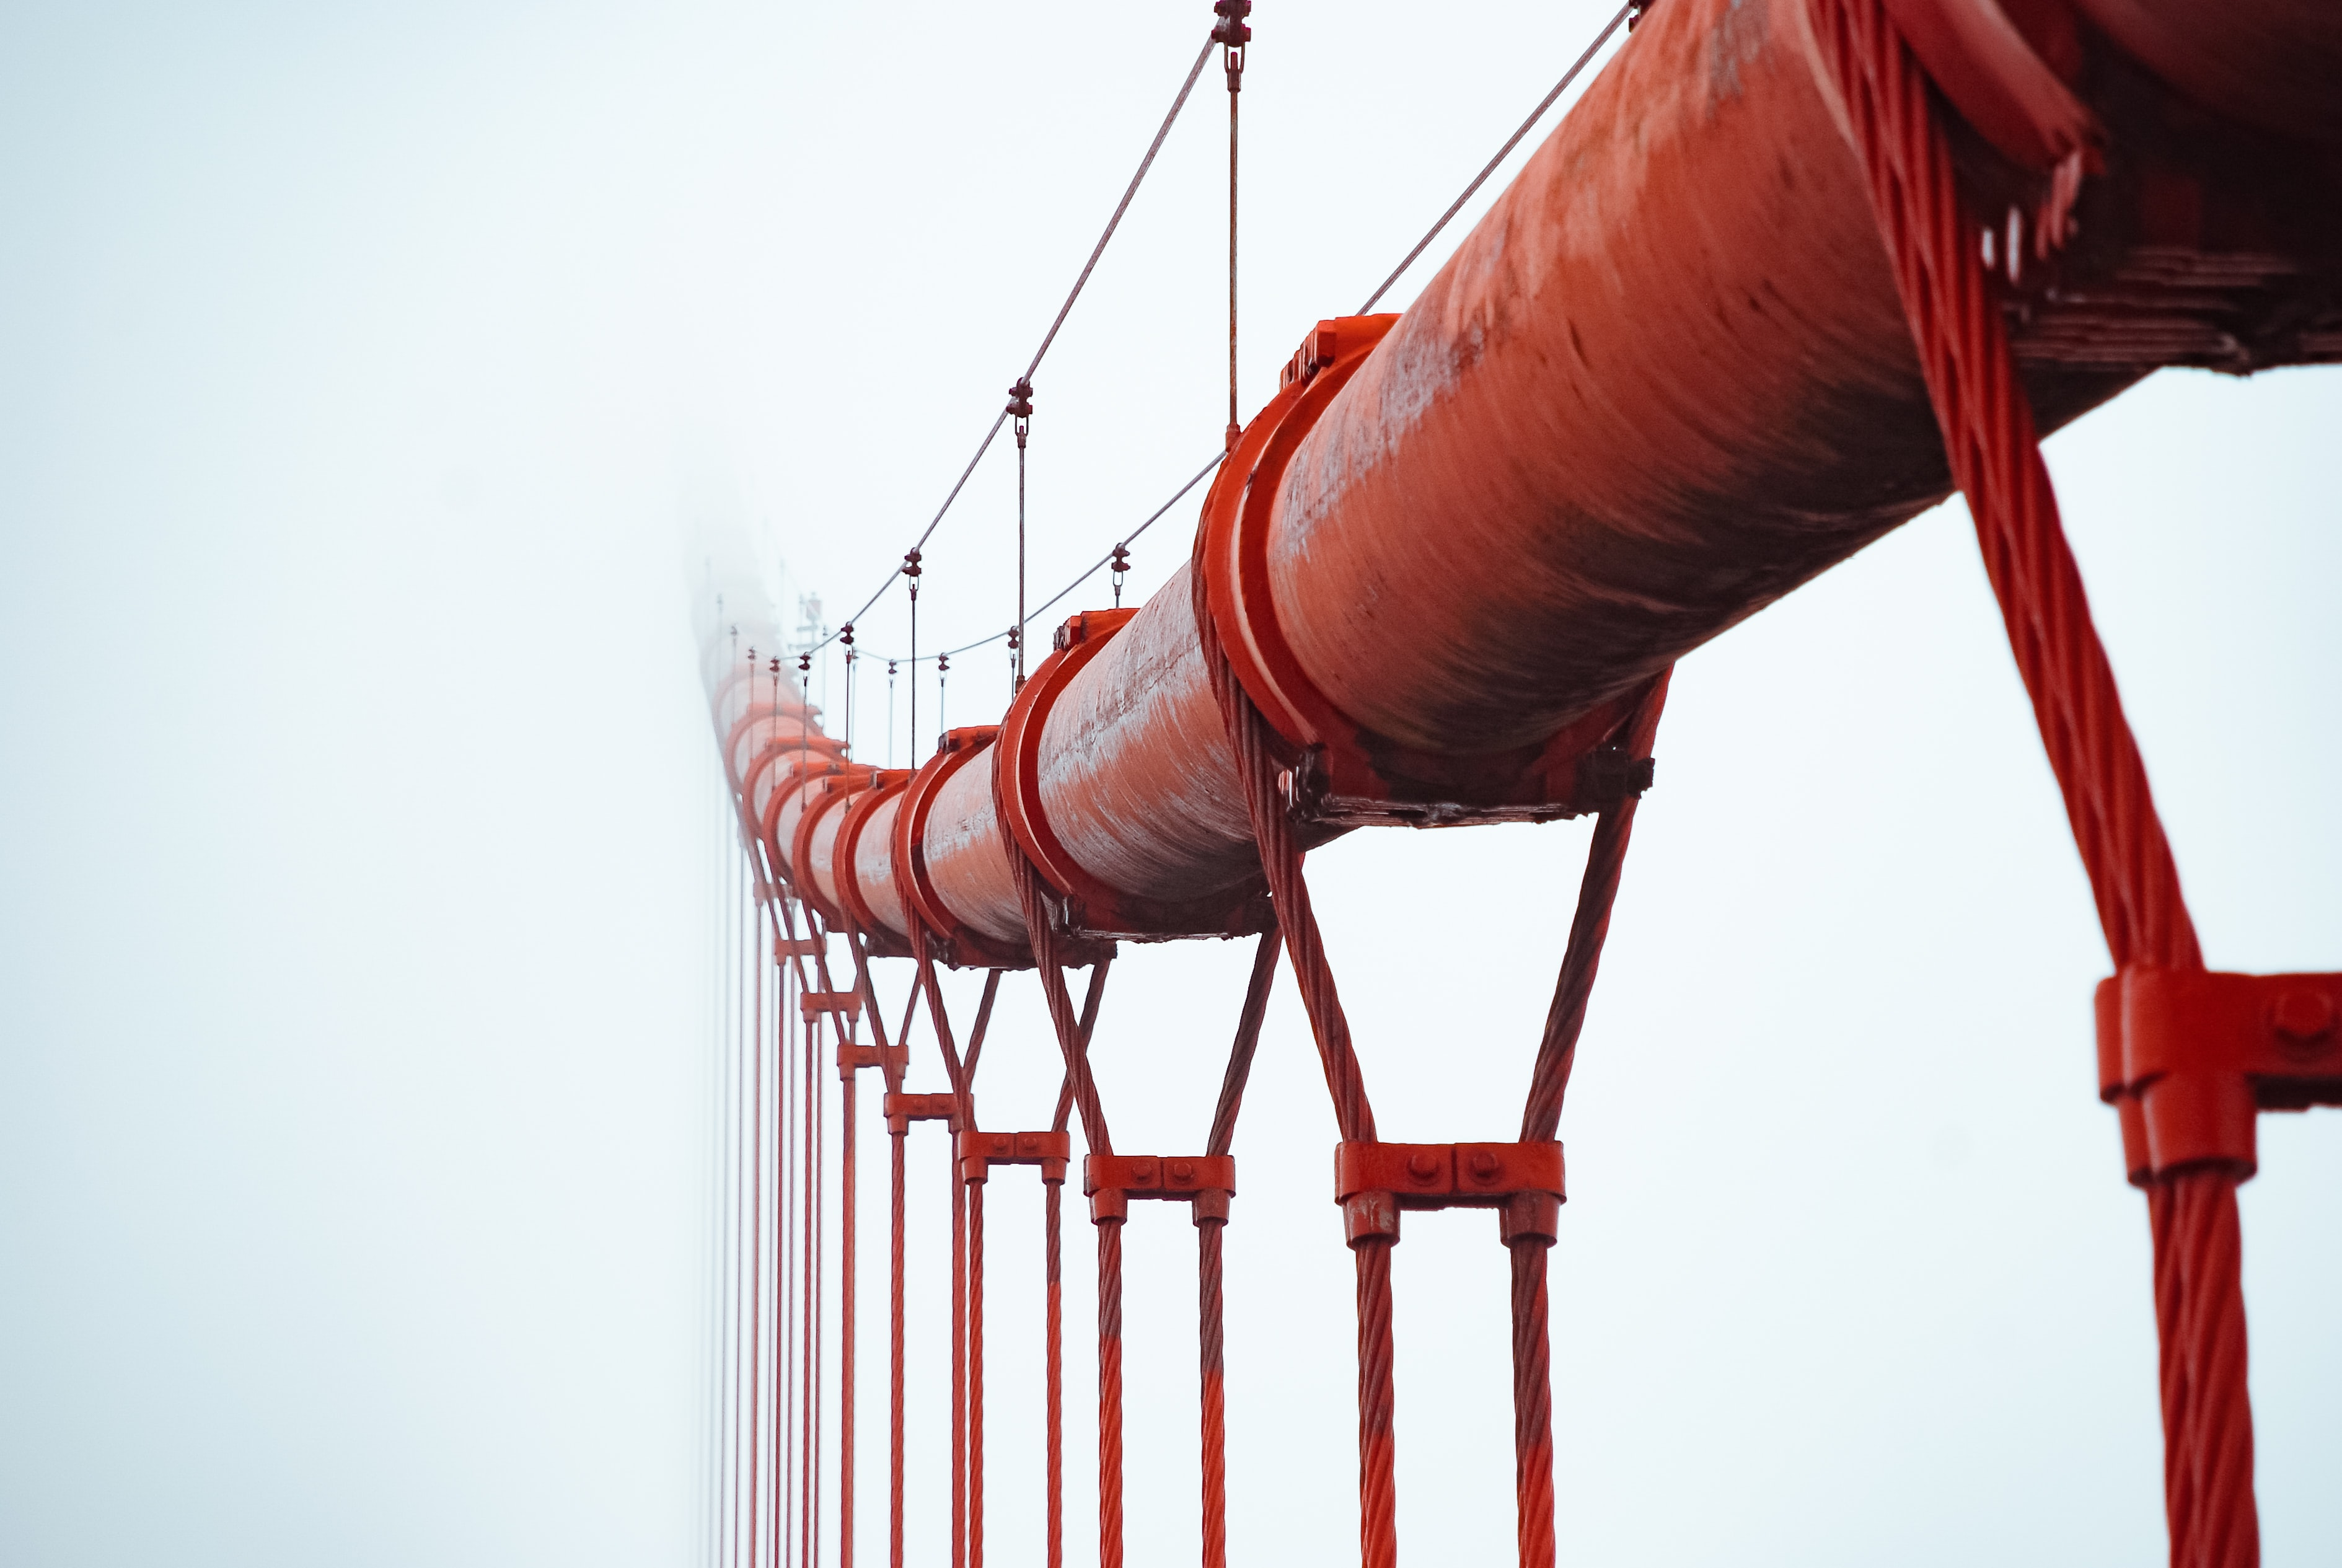

Photo by Danil Sorokin on Unsplash

# Table of Contents
* [Introduction](#introduction)
* [Pipelines](#pipelines)
    * [The Purpose of a pipeline](#purpose)
    * [Helper Functions](#functions)
    * [Loading Data](#loading)
    * [Getting Started](#gettingstarted)
* [Transformers](#transformers) 
    * [Custom Transformers](#customtransformers)
    * [Column Transformers](#columntransformers)
    * [Feature Unions](#featureunions)
* [Implementation](#implementation) 
    * [Implementing NameColumnTransformer](#namecolumntransformer)
    * [Implementing AgeColumnTransformer](#agecolumntransformer)
    * [Implementing CabinColumnTransformer](#cabincolumntransformer)
    * [Result of Applying Custom Transformers](#customtransformerresult)
    * [Implementing Column Transformer](#implementingcolumntransformer)
    * [Implementing Feature Union](#implementingfeatureunion)
    * [Implementing the Model](#implementingthemodel)
    * [Validation](#validation)
    * [Cross-Validation](#crossvalidation)
    * [Prediction](#prediction)
* [Submission](#submission) 
* [Conclusion](#conclusion) 
* [References](#references)


# Pipelines <a id='pipelines'></a>

A sklearn pipeline combines and links multiple estimators into one single estimator. Estimators are objects that learn from data; as a result, model algorithms (classification, regression, clustering) or a transformer that extracts/filters useful features from raw data are counted as estimators (they inherit from the same BaseEstimator class). Imputers and encoders are also estimators, and Estimators must have a fit method. While models also implement the predict method, transformers implement the transform method, as we will see below.

The Pipeline can be constructed using a list of (step_name, estimator) pairs. Below you can find an example taken from the [Scikit-learn official page](https://scikit-learn.org/stable/index.html).

```
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
```

## The Purpose of a pipeline <a id='purpose'></a>

Why is the binding of multiple estimators handy? There is often a fixed sequence of steps in processing the data, and by using pipelines, we combine those into one single step:

* We encapsulate the data by calling fit and predict only once on our data; this helps us write cleaner code, and as a result, fewer bugs are introduced.

* We can make a general parameter selection by using grid search in the pipeline. We will use grid search once and call all the parameters from the estimators altogether.

* Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation by ensuring that the same samples are used to train the transformers and predictors (prevent data leakage). 

One of the most essential features of a pipeline is that all estimators in a pipeline, except the last one, must be transformers (i.e., must have a transform method). The final estimator may be any type (transformer, classifier, etc.). In this notebook, we will use both pipelines ending with a model and pipelines consisting of transformers only.

Now let's check the data and begin our pipeline design... 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under
# the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as
# output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the
# current session
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from category_encoders import BinaryEncoder
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Helper Functions   <a id='functions'></a>   

We will use some helper functions throughout the notebook. Collecting them in one place is a good idea, making the code more organized.

In [2]:
# Functions

def get_titles(df):
    '''Get the set of titles from the Name field'''
    titles=set()
    for name in df:
        if name.find('.'):
            title = name.split('.')[0].split()[-1]
            titles.add(title)
    return titles


def get_family_name(df):
    '''Get the set of family names from Name field'''
    family_names=set()
    for name in df:
        if name.find(','):
            family_name = name.split(',')[0].split()[-1]
            family_names.add(family_name)
    return family_names

def get_cabin_chars(df):
    '''Get the set of chars used in Cabin field'''
    cabin_chars = set()
    for word in df:
        cabin_chars.add(str(word)[0]) 
    return cabin_chars

def save_file (predictions):
    """Save submission file."""
    # Save test predictions to file
    output = pd.DataFrame({'PassengerId': sample_sub_file.PassengerId,
                       'Survived': predictions})
    output.to_csv('submission.csv', index=False)
    print ("Submission file is saved")
    
print("Functions loaded")

Functions loaded


## Loading Data   <a id='loading'></a>   

We will first load the data. Next, we will drop the ticket column since we do not need it. Finally, we will split our data into training and test data sets.  

In [3]:
# Loading data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
sample_sub_file = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# Make a copy to avoid changing original data
X = train_data.copy()
y = X.Survived
X_test = test_data.copy()

# Remove target from predictors
X.drop(['Survived'], axis=1, inplace=True)
print('"Survived" column dropped from training data!')

# Remove ticket column. We will not use it.
X.drop("Ticket",axis = 1, inplace = True)
X_test.drop("Ticket",axis = 1, inplace = True)
print('"Ticket" column dropped from both training and test data!')

print("\nShape of training data: {}".format(X.shape))
print("Shape of target: {}".format(y.shape))
print("Shape of test data: {}".format(X_test.shape))
print("Shape of submission data: {}".format(sample_sub_file.shape))

# Split the data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=2)

print("\nShape of X_train data: {}".format(X_train.shape))
print("Shape of X_valid: {}".format(X_valid.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_valid: {}".format(y_valid.shape))

print("\nFiles Loaded")

"Survived" column dropped from training data!
"Ticket" column dropped from both training and test data!

Shape of training data: (891, 9)
Shape of target: (891,)
Shape of test data: (418, 9)
Shape of submission data: (418, 2)

Shape of X_train data: (668, 9)
Shape of X_valid: (223, 9)
Shape of y_train: (668,)
Shape of y_valid: (223,)

Files Loaded


## Getting Started   <a id='gettingstarted'></a>   

Since we all know the renowned Titanic dataset, there isn't much to tell at this stage. As previously stated, we have already dropped the Ticket column since we will not use it, so 9 columns remained.

In [4]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB


In [6]:
# Make Lists
# Get missing values
missing_values = [col for col in X_train.columns if X_train[col].isnull().sum()]
print("Cols with missing: {}".format(missing_values))

# get numerical and categorical columns
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64',
                                                                  'float64']]
print("Numerical columns: {}".format(numerical_columns))
categorical_columns = [col for col in X.columns if X[col].dtype=="object"]
print("Categorical columns: {}".format(categorical_columns))

# Get titles from the name column
titles = list(get_titles(X["Name"]))
print("\nTitles: {}".format(titles))

# Get chars from the cabin column
chars = list(get_cabin_chars(X["Cabin"]))
print("\nChars in Cabin column: {}".format(chars))

Cols with missing: ['Age', 'Cabin', 'Embarked']
Numerical columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns: ['Name', 'Sex', 'Cabin', 'Embarked']

Titles: ['Master', 'Mlle', 'Mme', 'Lady', 'Sir', 'Jonkheer', 'Mr', 'Countess', 'Mrs', 'Miss', 'Don', 'Col', 'Major', 'Capt', 'Dr', 'Rev', 'Ms']

Chars in Cabin column: ['T', 'A', 'G', 'D', 'n', 'E', 'B', 'C', 'F']


In [7]:
# Get surnames from the name column
surname = list(get_family_name(X["Name"]))
print("Surnames of the passengers: {}".format(surname))

Surnames of the passengers: ['Montvila', 'Ryan', 'Potter', "O'Brien", 'Culumovic', 'Fox', 'Kassem', 'Skoog', 'Kink-Heilmann', 'Fleming', 'Nye', 'Sundman', 'Harder', 'Slayter', 'Natsch', 'Baxter', 'Dakic', 'Coutts', 'Seward', 'Simmons', 'Allen', 'Yasbeck', 'Lurette', 'Rekic', 'Nosworthy', 'Hunt', 'Flynn', 'Sharp', 'Molson', 'Phillips', 'Cleaver', 'Fischer', 'McCormack', 'Moore', 'Karaic', 'Dantcheff', 'Novel', 'White', 'Willey', 'Kraeff', 'Sirota', 'Rogers', 'Hanna', 'Carlsson', 'Sutton', 'Minahan', 'Corn', 'Andrew', 'Horgan', 'Bazzani', 'Isham', 'Healy', 'Badt', 'Stahelin-Maeglin', 'Swift', "O'Connor", 'Homer', 'Artagaveytia', 'Davidson', 'Wiklund', 'Haas', 'Petroff', 'Givard', 'Richard', 'Alexander', 'Mockler', 'Francatelli', 'Leader', 'Harrington', 'McMahon', 'Carter', 'Green', 'Dorking', 'More', 'Weisz', 'Jonsson', 'Taylor', 'Nysveen', 'Eitemiller', 'Tobin', 'Thorne', 'Chronopoulos', 'Carrau', 'Foo', 'Somerton', 'Ivanoff', 'Panula', 'Hamalainen', 'Rice', 'Hassan', 'Silverthorne', 'H

We have 5 numerical columns and 4 categorical columns, and we also have 3 columns with missing values. One of them is numerical, and two of them are categorical. 

OK, what can we do with these 9 columns?

We need to impute the missing columns and encode categorical data. 

We can sum SibSp and Parch columns to see if the related person has a family on board.

We have a Name column where we can extract titles and surnames. There will be tons of surnames. We may reduce them by only counting the families (```SibSp + Parch > 0```) in the ship. Maybe the fate of the family members was alike. But we have to find a suitable encoder for them. One-hot encoding will bring too many columns. We can even differentiate high-rank society members such as Countess or Jonkheer from others. Maybe they have been favored more than the others.

The Cabin column has lots of null values. The valid values for this column start with a character and continue with numbers, and maybe we can extract those starting letters and use them.

We can make the initial design, but before starting, I want to emphasize again that our goal in this notebook is not to solve the Titanic challenge. I know that we will overfit the data by doing all the things we described above. This notebook's only purpose is to introduce the reader to the Sklearn pipelines. So we do not care about overfitting the data.

Our workflow will be as follows:

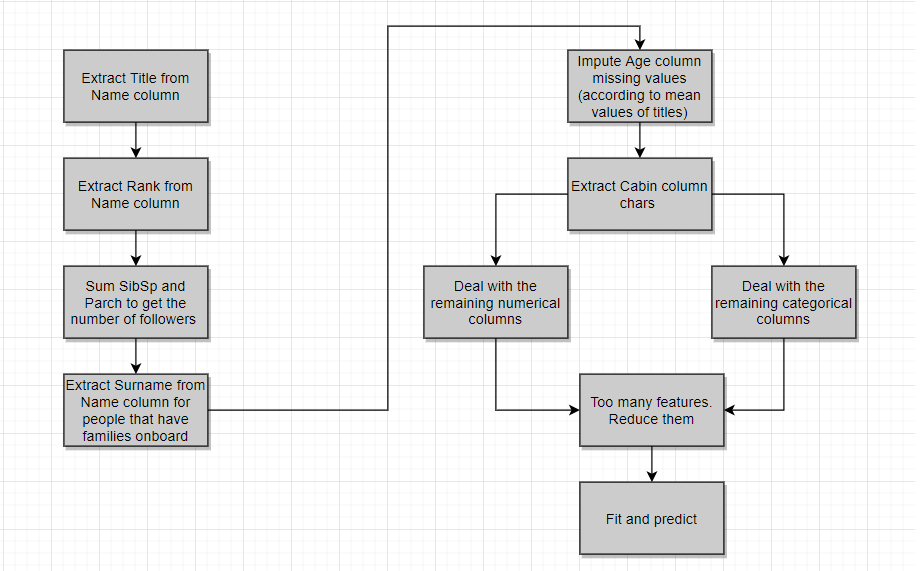



# Transformers <a id='transformers'></a>

We can separate machine learning workflow into different pieces. A pipeline generally contains a  pre-processing step that transforms/imputes the data and a final predictor that predicts target values. Similar to a regular estimator, a pipeline can be fitted/predicted. Pre-processors and transformers stick to the same API as the estimator objects (same BaseEstimator class). The transformer objects don’t have a prediction method as predictors have; however, they implement a transform method that outputs a newly transformed sample matrix X.
​
A fit method grasps model parameters (e.g., mean and standard deviation for normalization) from a training set, and a transform method applies this transformation model to unseen data. fit_transform may be more convenient and efficient for simultaneously modeling and transforming the training data.

## Custom Transformers   <a id='customtransformers'></a> 

If you search the net, you can find several blogs/posts that show how to implement a custom transformer. There are different ways to implement one, and you can even use Function Transformers of the Scikit-learn library. I have chosen the one below, which you can find in this [post](https://g-stat.com/using-custom-transformers-in-your-machine-learning-pipelines-with-scikit-learn/).

```
class CustomTransformer(BaseEstimator, TransformerMixin):
    """
    a general class for creating a machine learning step in the machine
    learning pipeline
    """
    def __init__(self):
        """
        constructor
        """
        super(CustomTransformer, self).__init__()

    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by
        examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer
        - Transformer
        """
        pass

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend
        in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        pass

    def fit_transform(self, X, y=None, **kwargs):
        """
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        return self.transform(X, y)
```

## Column Transformers   <a id='columntransformers'></a>

Datasets generally consist of different data types (floats, dates, strings, etc.). We need to deal with those data types separately. 

Using ColumnTransformer different transformations can be made for columns of the data within a Pipeline that is safe from data leakage and that can be parameterized. ColumnTransformer works on arrays, sparse matrices, and pandas DataFrames.

A different transformation can be applied to each column, such as preprocessing or a specific feature extraction method. 

Below you can find a column ColumnTransformer example from [Intermediate Machine Learning Course](https://www.kaggle.com/alexisbcook/pipelines) on [Kaggle Learn](https://www.kaggle.com/learn/overview)

```
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
```

## Feature Unions   <a id='featureunions'></a>

FeatureUnion combines several transformer objects into a new transformer that combines their output. A FeatureUnion takes a list of transformer objects. During fitting, each of these is fit to the data independently. The transformers are applied in parallel, and the created feature matrices are concatenated side-by-side into a larger matrix.

FeatureUnion serves the same purposes as Pipeline - convenience and joint parameter estimation and validation.

FeatureUnion and Pipeline can be combined to create complex models.

A FeatureUnion is built using a list of (key, value) pairs, where the '*key*' is the name you want to give to a given transformation (an arbitrary string; it only serves as an identifier), and the '*value*' is an estimator object. 

Below you can find an example taken from the [Scikit-learn official page](https://scikit-learn.org/stable/index.html).

```
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
estimators = [('linear_pca', PCA()), ('kernel_pca', KernelPCA())]
combined = FeatureUnion(estimators)

```

Since we learned all we need, we can make a pipeline structure for our data. According to the workflow above, our pipeline structure will be as follows:

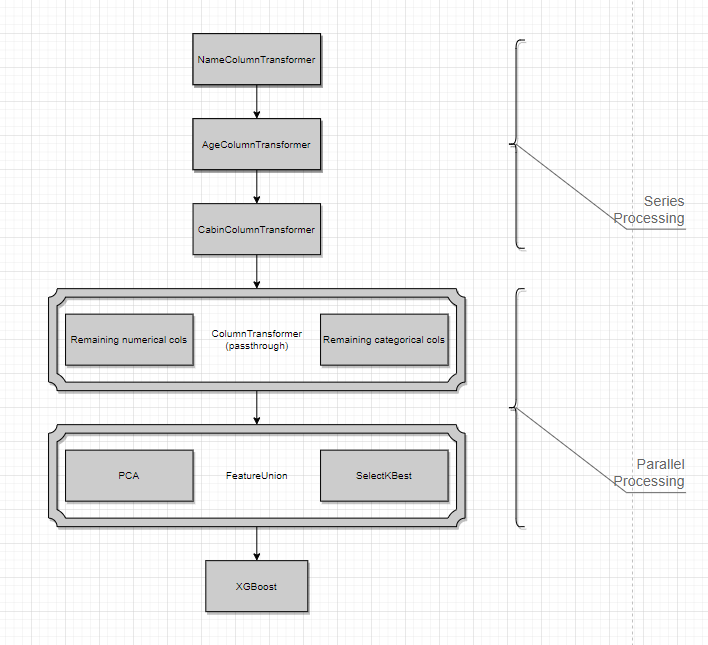

# Implementation <a id='implementation'></a>

It is time for the implementation of the pipeline. We will start with the custom transformers and implement the constructor, fit, transform, and fit_transform methods.

In the fit method, we will learn from the data and store necessary information in the object variables. 

In the transform method, we will use object variables to transform the data at hand.

In the fit_transform method, we will call the fit and transform functions successively.

## Implementing NameColumnTransformer <a id='namecolumntransformer'></a>

In the NameColumnTransformer class, we will:

* Extract the title from the name column,
* Extract the Rank from the name column,
* Sum SibSp and Parch to get the number of followers,
* Extract the Surname from the Name column for people with families on board (we will use binary encoding).

You can read the comments to catch what is going on.

In [8]:
# Custom transformer classes
class NameColumnTransformer(BaseEstimator, TransformerMixin):
    """
    a general class for transforming Name, SibSp and Parch columns of Titanic dataset
    for using in the machine learning pipeline
    """
    def __init__(self):
        """
        constructor
        """
        # Will be used for fitting data
        self.titles_set = set()
        self.surname_set = set()
        # Titles captured from train data
        self.normal_titles_list = ["Mr", "Mrs", "Mme", "Miss", "Mlle", "Ms", "Master", "Dona"]
        self.titles_dict = {"Mr": ['Mr', 'Major', 'Jonkheer', 'Capt', 'Col', 'Don', 'Sir',
                                   'Rev'],
                            "Mrs": ['Mrs', 'Mme', 'Lady','Countess', 'Dona'],
                            "Miss": ['Miss', 'Mlle', 'Ms'],
                            "Master": ['Master'],
                            "Dr": ['Dr']}

    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        '''Fits the titles, family and rank from Names Column'''
        
        # Make a copy to avoid changing original data
        X_temp = X.copy()
        # Create Titles column
        if "Title" in X_temp.columns:
            X_temp.drop("Title", axis=1, inplace=True)
        else:
            pd.DataFrame.insert(X_temp, len(X_temp.columns),"Title","",False)  
            
        # Get the index values
        index_values=X_temp.index.values.astype(int)
        
        # Set state (Add to: {titles_set, surname_set} attributes) of the object
        for i in index_values:
            
            # Get the name for the ith index
            name = X_temp.loc[i,'Name']
            # Get the number of followers for the ith index
            number_of_followers = X_temp.loc [i, 'SibSp'] + X_temp.loc [i, 'Parch']
            
            # Split the title from name
            if name.find('.'):
                title = name.split('.')[0].split()[-1]
                if title in self.titles_dict.keys():
                    X_temp.loc[i, 'Title'] = title
                else:
                    X_temp.loc[i, 'Title'] = np.NaN
                # Add title to titles_set to use in transform method
                self.titles_set.add(title)
            
            # Split the surname from name
            if name.find(','):
                surname = name.split(',')[0].split()[-1]
                # Add surname to surname_set to use in transform method
                if number_of_followers > 0:
                    self.surname_set.add(surname)
                    X_temp.loc[i,"Family"]=surname
                
        # Title Encoding
        
        # Drop missing Title rows (Hi rank columns that are mapped to titles_dict keys)
        # so that no 'Title_' columns will appear in transform 
        X_temp.dropna(axis = "index", subset=['Title'], inplace=True)
        
        # Apply one-hot encoding to the Title column.
        self.OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        # Get column names to use in transform.
        self.OH_encoder = self.OH_encoder.fit(X_temp[['Title']])
        self.title_columns = self.OH_encoder.get_feature_names(['Title'])

        # Family Encoding
        
        # Drop missing Family rows
        # so that no 'Family_' columns will appear in transform 
        X_temp.dropna(axis = "index", subset=['Family'], inplace=True)
        
        # Apply binary encoding to the Family column.
        self.binary_encoder = BinaryEncoder(cols =['Family'])
        self.binary_encoder = self.binary_encoder.fit(X_temp[['Family']])
        
        return self

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        '''Transforms the titles and family from Names Column'''
        
        # Make a copy to avoid changing original data
        X_temp = X.copy()
        
        # Create Titles column    
        pd.DataFrame.insert(X_temp, len(X_temp.columns),"Title","",False)    
        # Create Family column
        pd.DataFrame.insert(X_temp, len(X_temp.columns),"Family","",False)          
        # Create Rank column
        pd.DataFrame.insert(X_temp, len(X_temp.columns),"Rank","",False)
        # Create Followers column
        pd.DataFrame.insert(X_temp, len(X_temp.columns),"Followers","",False)
        
        # Get the index values
        index_values=X_temp.index.values.astype(int)
        
        for i in index_values:
            # Get the name for the ith index
            name = X_temp.loc[i,'Name']
            # Get the number of followers for the ith index
            number_of_followers = X_temp.loc [i, 'SibSp'] + X_temp.loc [i, 'Parch']
            X_temp.loc[i, 'Followers'] = number_of_followers
            
            # Split the title from name
            if name.find('.'):
                title = name.split('.')[0].split()[-1]
                if title in self.titles_set:
                    for key in self.titles_dict:
                        # Insert title
                        if title in self.titles_dict[key]:
                            X_temp.loc[i, 'Title'] = key 
                        
                        # Insert rank
                        if title in self.normal_titles_list:
                            X_temp.loc[i, 'Rank'] = "Normal"
                        else:
                            X_temp.loc[i, 'Rank'] = "High"
                else:
                    X_temp.loc[i, 'Title'] = "Other"
                    X_temp.loc[i, 'Rank'] = "Normal"
                    
                    
            # Split the surname from name
            if name.find(','):
                surname = name.split(',')[0].split()[-1]
                if surname in self.surname_set and number_of_followers > 0:
                    X_temp.loc[i, 'Family'] = surname                 
                else:
                    X_temp.loc[i, 'Family'] = "NA"                    
        
        # Encoding Title
        encoded = self.OH_encoder.transform(X_temp[['Title']])
        # convert arrays to a dataframe 
        encoded = pd.DataFrame(encoded) 
        # One-hot encoding removed index; put it back
        encoded.index = X_temp.index
        # Insert column names
        encoded.columns = self.title_columns
        encoded = encoded.astype('int64')
        # concating dataframes  
        X_temp = pd.concat([X_temp, encoded], axis = 1)
        
        # Encoding Family
        bin_encoded = self.binary_encoder.transform(X_temp[['Family']])
        # convert arrays to a dataframe 
        bin_encoded = pd.DataFrame(bin_encoded) 
        # One-hot encoding removed index; put it back
        bin_encoded.index = X_temp.index
        bin_encoded = bin_encoded.astype('int64')
        # concating dataframes  
        X_temp = pd.concat([X_temp, bin_encoded], axis = 1)
        # We do not need Family any more
        X_temp.drop("Family", axis = 1, inplace=True) 
        
        # Encoding Rank
        X_temp['Rank'] = X_temp['Rank'].apply(lambda x: 1 if x =='Normal' else (0 if x =='High' else None))
        # We do not need Name any more
        X_temp.drop("Name", axis = 1, inplace=True)

        return X_temp

    def fit_transform(self, X, y=None, **kwargs):
        """
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        return self.transform(X, y)
print("NameColumnTransformer loaded")

NameColumnTransformer loaded


## Implementing AgeColumnTransformer <a id='agecolumntransformer'></a>

In the AgeColumnTransformer class, we will:

* Impute the missing values in the age column by using the mean values of each title. As a result, no master will be at the age of 30.

You can read the comments to catch what is going on.

In [9]:
# Custom transformer classes
class AgeColumnTransformer(BaseEstimator, TransformerMixin):
    """
    a general class for transforming age column of Titanic dataset for using in the machine learning pipeline
    """
    def __init__(self):
        """
        constructor
        """
        # Will be used for fitting data
        self.titles_set = set()
        self.titles_dict = {}


    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        '''Fits the titles, family and rank from Names Column'''
 
        # Make a copy to avoid changing original data
        X_temp = X.copy()
    
        # Get the index values
        index_values = X_temp.index.values.astype(int)
        
        # Get all the titles from dataset
        for i in index_values:
            title = X_temp.loc [i, 'Title']
            self.titles_set.add(title)
        
        # Calculate mean for all titles
        for title in self.titles_set:
            mean = self.calculate_mean_age(title, X_temp)
            self.titles_dict[title] = mean
            #print("Avarage age for title '{}' is {}".format(title, mean))
       
        return self

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        '''Transforms the titles and family from Names Column'''
            
        # Make a copy to avoid changing original data
        X_temp = X.copy()        
        
        # Get the index values
        index_values = X_temp.index.values.astype(int)
        
        # If a passangers age is Nan replace it with the avarage value
        # of that title class. e.g. if that passanger is master use the
        # mean value calculated for the masters.
        for i in index_values:
            age = X_temp.at[i, 'Age'].astype(float)
            if np.isnan(age):
                title = X_temp.loc [i, 'Title']
                X_temp.loc[i,'Age'] =  round(self.titles_dict.get(title),2)

        # We do not need Title any more
        X_temp.drop("Title", axis = 1, inplace=True)
        
        return X_temp

    def fit_transform(self, X, y=None, **kwargs):
        """
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        
        return self.transform(X, y)
                   
    def calculate_mean_age(self, title, X):
        
        # Make a copy to avoid changing original data
        X_temp = X.copy()  
        
        title_X = X_temp[[title in x for x in X_temp['Title']]][X_temp["Age"].notnull()]
        return title_X["Age"].mean()

    print("AgeColumnTransformer loaded")

AgeColumnTransformer loaded


## Implementing CabinColumnTransformer <a id='cabincolumntransformer'></a>

In the CabinColumnTransformer class, we will:

* Extract the first char of the Cabin column values.

You can read the comments to catch what is going on.

In [10]:
# Custom transformer classes
class CabinColumnTransformer(BaseEstimator, TransformerMixin):
    """
    a general class for transforming cabin column of Titanic dataset for using in the machine 
    learning pipeline
    """
    def __init__(self):
        """
        constructor
        """
        # Will be used for fitting data
        self.cabin_set = set()

    def fit(self, X, y=None, **kwargs):
        """
        an abstract method that is used to fit the step and to learn by examples
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: self: the class object - an instance of the transformer - Transformer
        """
        '''Fits the titles, family and rank from Names Column'''
         
        # Make a copy to avoid changing original data
        X_temp = X.copy()
        
        # Imputation on X_temp_imputed
        imputer = SimpleImputer(strategy='constant', fill_value="NaN")
        X_temp_imputed = pd.DataFrame(imputer.fit_transform(X_temp[['Cabin']]))
        # Imputation removed column names; put them back
        X_temp_imputed.columns = X_temp[['Cabin']].columns
        X_temp_imputed.index = X_temp[['Cabin']].index
    
        # Get the index values
        index_values = X_temp.index.values.astype(int)
        
        # For each cabin
        for i in index_values:
            cabin = X_temp_imputed.loc[i, 'Cabin']
            X_temp_imputed.loc[i, 'Cabin'] = cabin[0]
            self.cabin_set.add(cabin[0])
        
        # Cabin Encoding
        
        # Apply one-hot encoding to the Cabin column.
        self.OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        # Get column names to use in transform.
        self.OH_encoder = self.OH_encoder.fit(X_temp_imputed[['Cabin']])
        self.cabin_columns = self.OH_encoder.get_feature_names(['Cabin'])
      
        return self

    def transform(self, X, y=None, **kwargs):
        """
        an abstract method that is used to transform according to what happend in the fit method
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        '''Transforms the titles and family from Names Column'''

        # Make a copy to avoid changing original data
        X_temp = X.copy()        
        
        # Get the index values
        index_values = X_temp.index.values.astype(int)
        
        # Imputation on X_imputed
        imputer = SimpleImputer(strategy='constant', fill_value="NaN")
        X_imputed = pd.DataFrame(imputer.fit_transform(X_temp[['Cabin']]))
        # Imputation removed column names; put them back
        X_imputed.columns = X_temp[['Cabin']].columns
        X_imputed.index = X_temp[['Cabin']].index
        
        for i in index_values:
            cabin = X_imputed.loc[i, 'Cabin']
            if cabin[0] in self.cabin_set:
                X_imputed.loc [i, 'Cabin'] = cabin[0]
            else:
                X_imputed.loc [i, 'Cabin'] = "N"
        X_temp.drop("Cabin",axis = 1, inplace = True)

        # concating dataframes  
        X_temp = pd.concat([X_temp, X_imputed], axis = 1)
               
        # Encoding Cabin
        encoded = self.OH_encoder.transform(X_imputed[['Cabin']])
        # convert arrays to a dataframe 
        encoded = pd.DataFrame(encoded) 
        # One-hot encoding removed index; put it back
        encoded.index = X_imputed.index
        # Insert column names
        encoded.columns = self.cabin_columns
        encoded = encoded.astype('int64')
        # concating dataframes  
        X_temp = pd.concat([X_temp, encoded], axis = 1)

        X_temp.drop("Cabin",axis = 1, inplace = True)
        
        return X_temp

    def fit_transform(self, X, y=None, **kwargs):
        """
        perform fit and transform over the data
        :param X: features - Dataframe
        :param y: target vector - Series
        :param kwargs: free parameters - dictionary
        :return: X: the transformed data - Dataframe
        """
        self = self.fit(X, y)
        return self.transform(X, y)

    print("CabinColumnTransformer loaded")

CabinColumnTransformer loaded


## Result of Applying Custom Transformers<a id='customtransformerresult'></a>

OK, I guess we all wonder what the result of applying those custom transformers to our data set is. But we must be careful at this stage. We have used the results of NameColumnTransformer at AgeColumnTransformer. As a result, we need to transform our data using NameColumnTransformer first. Then we can use AgeColumnTransformer. Let's remember our training set and then apply custom transformations and see the result.

In [11]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [12]:
# Apply NameColumnTransformer
name = NameColumnTransformer()
X_name=name.fit_transform(X) 

# Apply AgeColumnTransformer
age=AgeColumnTransformer()
X_age=age.fit_transform(X_name) 

# Apply CabinColumnTransformer
cabin=CabinColumnTransformer()
X_cabin=cabin.fit_transform(X_age) 

X_cabin.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Rank,Followers,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Family_0,Family_1,Family_2,Family_3,Family_4,Family_5,Family_6,Family_7,Family_8,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,female,38.0,1,0,71.2833,C,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,3,female,26.0,0,0,7.9250,S,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,female,35.0,1,0,53.1000,S,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
5,3,male,35.0,0,0,8.0500,S,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
# Define the custom transformers for the pipeline
name_transformer = NameColumnTransformer()
age_transformer = AgeColumnTransformer()
cabin_transformer = CabinColumnTransformer()

## Implementing Column Transformer<a id='implementingcolumntransformer'></a>

Everything looks good. Now we can transform the other columns ('Pclass', 'Fare', 'Sex', 'Embarked') by using ColumnTransformer. However, there is a trick here. We need to set the remainder parameter of the column transformer as 'passthrough.' Otherwise, the remaining columns of our data will not be available after the transformation.

In [14]:
# Define the columns that will be handled by the column transformer
numerical_cols = ['Pclass', 'Fare']
categorical_cols = ['Sex', 'Embarked']

In [15]:
# Define transformers for numerical columns using a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])


# Define transformers for categorical columns using a pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

# Define column transformer for numerical and categorical data
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ], remainder='passthrough')

## Implementing Feature Union<a id='implementingfeatureunion'></a>

The feature union is directly taken from the [Scikit-learn official page](https://scikit-learn.org/stable/index.html). The primary purpose is how to use a feature union within a pipeline.

In [16]:
# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=12)

# Define union
feature_union = FeatureUnion([('pca', pca), ('select', selection)])

## Implementing the Model<a id='implementingthemodel'></a>

We will use XGBClassifier from the sklearn library.

In [17]:
# Define the model
my_model = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 seed=42)

## Validation<a id='validation'></a>

We have one final trick at the end. If we want to use early_stopping_rounds with our pipeline, we cannot use them directly. This is because sklearn pipelines do not process the eval_set used with early_stopping_rounds. As a result, we need to process our validation set before using early_stopping_rounds.

We can do this by chaining all our transformers (except the model) in a pipeline (only transformers) and using it to transform the validation set as below.

In [18]:
# Define preprocessor
preprocessor = Pipeline(steps=[('name', name_transformer),
                              ('age', age_transformer),
                              ('cabin', cabin_transformer),
                              ('column', column_transformer),
                              ('union', feature_union)])

# Make a copy to avoid changing original data 
X_valid_eval=X_valid.copy()

# Preprocessing of validation data
X_valid_eval = preprocessor.fit(X_train, y_train).transform (X_valid_eval)

In [19]:
# Display the number of remaining columns after transformation 
print("We have", X_valid_eval.shape[1], "features left")

We have 14 features left


In [20]:
# Define XGBoostClassifier fitting parameters for the pipeline
fit_params = {"model__early_stopping_rounds": 50,
              "model__eval_set": [(X_valid_eval, y_valid)],
              "model__verbose": True,
              "model__eval_metric" : "error"}

In [21]:
# Create and Evaluate the Pipeline
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train, **fit_params)

# Get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)

print("Score: {}".format(score))

[0]	validation_0-error:0.24215
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.20179
[2]	validation_0-error:0.19282
[3]	validation_0-error:0.17937
[4]	validation_0-error:0.18834
[5]	validation_0-error:0.18834
[6]	validation_0-error:0.18834
[7]	validation_0-error:0.18386
[8]	validation_0-error:0.18834
[9]	validation_0-error:0.18834
[10]	validation_0-error:0.18834
[11]	validation_0-error:0.18834
[12]	validation_0-error:0.18386
[13]	validation_0-error:0.18386
[14]	validation_0-error:0.18386
[15]	validation_0-error:0.18834
[16]	validation_0-error:0.18386
[17]	validation_0-error:0.17489
[18]	validation_0-error:0.17489
[19]	validation_0-error:0.17040
[20]	validation_0-error:0.17489
[21]	validation_0-error:0.17489
[22]	validation_0-error:0.17489
[23]	validation_0-error:0.17489
[24]	validation_0-error:0.17489
[25]	validation_0-error:0.17489
[26]	validation_0-error:0.17489
[27]	validation_0-error:0.17937
[28]	validation_0-error:0.18386
[29]	validation_

## Cross-Validation<a id='crossvalidation'></a>

We can also cross-validate our pipeline.

In [22]:
cv_model = XGBClassifier(learning_rate =0.01,
                         n_estimators=40,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         seed=42)

cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', cv_model)
                             ])

    
scores = cross_val_score(cv_pipeline, X_train, y_train,
                              cv=5,
                              scoring='accuracy')

print("Accuracy of the folds:\n", scores)
print("\nmean:\n", scores.mean())
print("std:\n", scores.std())

Accuracy of the folds:
 [0.82835821 0.82835821 0.82089552 0.82706767 0.78947368]

mean:
 0.8188306587363933
std:
 0.014936481396156881


Cross-validation seems reasonable. We can now check our validation set with our cross-validated model. That is the same value as the early_stopping_rounds example above, as expected. 

In [23]:
# Preprocessing of training data, fit model 
cv_pipeline.fit(X_train, y_train)

# Get predictions
preds = cv_pipeline.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)

print("Score: {}".format(score))

Score: 0.8340807174887892


## Prediction   <a id='prediction'></a>

Everything looks cool. We can now use our full dataset and submit our predictions.

In [24]:
# Preprocessing of training data, fit model 
cv_pipeline.fit(X, y)

# Get predictions
preds = cv_pipeline.predict(X_test)

# Submission   <a id='submission'></a>

We will use our utility function to create a submission file.

In [25]:
# Save submission file
save_file(preds)

Submission file is saved


# Conclusion   <a id='conclusion'></a>

Our submission score came to be 0,78708. As we all expected, it is far too small than our validation score, suggesting an overfit. On the other hand, maybe our model was not good enough to be generalized. Anyway, as I have already stated, the primary intention of this Notebook is to introduce the reader to Scikit-learn pipelines.

To summarize, we have learned the following concepts throughout this Notebook:

* Pipelines,
* Estimators,
* fit and transform mechanism,
* Custom Transformers,
* Column Transformers,
* Feature Unions,
* Implementing a Scikit-learn pipeline from start to end with tabular data.

Thank you all for reading to the end.

# References    <a id='references'></a>  
* [Scikit-Learn Pipelines with Custom Transformer — A Step by Step Guide](https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc)
* [Using Custom Transformers in Your Machine Learning Pipelines with scikit-learn](https://g-stat.com/using-custom-transformers-in-your-machine-learning-pipelines-with-scikit-learn/)
* [Dataset Transformations - Scikit-learn](https://scikit-learn.org/stable/data_transforms.html)
* [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/cross_validation.html)
* [Using scikit-learn Pipelines and FeatureUnions](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html)
* [Intermediate Machine Learning Course - Pipelines](https://www.kaggle.com/alexisbcook/pipelines)
* [Feature Encoding Techniques](https://www.geeksforgeeks.org/feature-encoding-techniques-machine-learning/) 
* [@alexisbcook](https://www.kaggle.com/alexisbcook)    
* [Kaggle Learn](https://www.kaggle.com/learn/overview)